In [167]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.special import boxcox1p
import pickle
from os import path
import statsmodels.api as sm
import warnings

warnings.filterwarnings("ignore")

# data Visualization
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import plotly.express as px 
from plotnine import ggplot, aes, geom_line, geom_point, facet_wrap, theme
import plotly.graph_objects as go
# Machine learning algorithms and model evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import bayesian_search_forecaster
from lightgbm import LGBMRegressor
# Encoding
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [168]:
features = pd.read_csv('Resources/features.csv')
stores = pd.read_csv("Resources/stores.csv")
train = pd.read_csv("Resources/train.csv")
df = pd.read_csv('Resources/walmart-sales-dataset-of-45stores.csv')

EDA for the Features dataset.

In [169]:
features.tail()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False
8189,45,2013-07-26,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,False


In [170]:
# Counting NaN values in each column of the 'features' DataFrame
nan_counts = features.isna().sum()

# Displaying the total NaN counts for each column
print(nan_counts)

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64


In [171]:
features.shape

(8190, 12)

In [172]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


In [173]:
features.describe()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,8190.000000,8190.000000,8190.000000,4032.000000,2921.000000,3613.000000,3464.000000,4050.000000,7605.000000,7605.000000
mean,23.000000,59.356198,3.405992,7032.371786,3384.176594,1760.100180,3292.935886,4132.216422,172.460809,7.826821
std,12.987966,18.678607,0.431337,9262.747448,8793.583016,11276.462208,6792.329861,13086.690278,39.738346,1.877259
min,1.000000,-7.290000,2.472000,-2781.450000,-265.760000,-179.260000,0.220000,-185.170000,126.064000,3.684000
25%,12.000000,45.902500,3.041000,1577.532500,68.880000,6.600000,304.687500,1440.827500,132.364839,6.634000
50%,23.000000,60.710000,3.513000,4743.580000,364.570000,36.260000,1176.425000,2727.135000,182.764003,7.806000
75%,34.000000,73.880000,3.743000,8923.310000,2153.350000,163.150000,3310.007500,4832.555000,213.932412,8.567000
max,45.000000,101.950000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,228.976456,14.313000


In [174]:
null_counts = features.isnull().sum()
print(null_counts)

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64


In [175]:
has_nulls = features.isnull().any()
print(has_nulls)

Store           False
Date            False
Temperature     False
Fuel_Price      False
MarkDown1        True
MarkDown2        True
MarkDown3        True
MarkDown4        True
MarkDown5        True
CPI              True
Unemployment     True
IsHoliday       False
dtype: bool


In [176]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [177]:
stores.shape

(45, 3)

In [178]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [179]:
stores.describe()

,Store,Size
count,45.000000,45.000000
mean,23.000000,130287.600000
std,13.133926,63825.271991
min,1.000000,34875.000000
25%,12.000000,70713.000000
50%,23.000000,126512.000000
75%,34.000000,202307.000000
max,45.000000,219622.000000


EDA on the train dataset.

In [180]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [181]:
train.shape

(421570, 5)

In [182]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [183]:
train.describe()

,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123
std,12.785297,30.492054,22711.183519
min,1.000000,1.000000,-4988.940000
25%,11.000000,18.000000,2079.650000
50%,22.000000,37.000000,7612.030000
75%,33.000000,74.000000,20205.852500
max,45.000000,99.000000,693099.360000


In [184]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [185]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [186]:
df["Date"] = pd.to_datetime(df["Date"], format="%d-%m-%Y")

In [187]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   int64         
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 402.3 KB


Dealing with missing values on the features dataset, we know from the initial EDA on the Features dataset that both CPI and Unemployment have missing values. We will fill these missing values with the median of the respective columns.

In [188]:
# Counting NaN values for 'CPI' and 'Unemployment' columns in the 'features' DataFrame
nan_counts_specific = features[["CPI", "Unemployment"]].isna().sum()

# Displaying the NaN counts for 'CPI' and 'Unemployment'
print(nan_counts_specific)

CPI             585
Unemployment    585
dtype: int64


In [189]:
#filling in the NaN values in the 'CPI' and 'Unemployment' columns with the median of each column.
features = features.fillna({"CPI": features["CPI"].median()})
features = features.fillna({"Unemployment": features["Unemployment"].median()})

The for loop is addressing the Markdown columns missing data. The missing data in the Markdown columns will be filled with 0. The values below were calculated from the Features dataset in the EDA process.

```python
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140

In [ ]:
for i in range(1, 6):
    features.loc[:, "MarkDown" + str(i)] = (
        features["MarkDown" + str(i)]
        .mask(features["MarkDown" + str(i)] < 0, 0)
        .fillna(0)
    )

In [ ]:
# confirming we do not have any missing values.
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     8190 non-null   float64
 5   MarkDown2     8190 non-null   float64
 6   MarkDown3     8190 non-null   float64
 7   MarkDown4     8190 non-null   float64
 8   MarkDown5     8190 non-null   float64
 9   CPI           8190 non-null   float64
 10  Unemployment  8190 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


Combining the training dataset with the features dataset using merge.

In [ ]:
data = pd.merge(train, stores, on="Store", how="left")

In [ ]:
data = pd.merge(data, features, on=["Store", "Date"], how="left")

In [ ]:
data["Date"] = pd.to_datetime(data["Date"])

In [ ]:
data.sort_values(by=["Date"], inplace=True)

In [ ]:
data.set_index(data.Date, inplace=True)

In [ ]:
data["IsHoliday_x"].isin(data["IsHoliday_y"]).all()

True

In [ ]:
data.drop(columns="IsHoliday_x", inplace=True)
data.rename(columns={"IsHoliday_y": "IsHoliday"}, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421570 entries, 2010-02-05 to 2012-10-26
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   Type          421570 non-null  object        
 5   Size          421570 non-null  int64         
 6   Temperature   421570 non-null  float64       
 7   Fuel_Price    421570 non-null  float64       
 8   MarkDown1     421570 non-null  float64       
 9   MarkDown2     421570 non-null  float64       
 10  MarkDown3     421570 non-null  float64       
 11  MarkDown4     421570 non-null  float64       
 12  MarkDown5     421570 non-null  float64       
 13  CPI           421570 non-null  float64       
 14  Unemployment  421570 non-null  float64       
 15  I

In [ ]:
data.head()

,Store,Dept,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
Date,,,,,,,,,,,,,,,,
2010-02-05,1,1,2010-02-05,24924.50,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False
2010-02-05,29,5,2010-02-05,15552.08,B,93638,24.36,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,10.064,False
2010-02-05,29,6,2010-02-05,3200.22,B,93638,24.36,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,10.064,False
2010-02-05,29,7,2010-02-05,10820.05,B,93638,24.36,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,10.064,False
2010-02-05,29,8,2010-02-05,20055.64,B,93638,24.36,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,10.064,False


Seperating out the date columns

In [ ]:
data["Year"] = data["Date"].dt.year
data["Month"] = data["Date"].dt.month
data["Week"] = data["Date"].dt.isocalendar().week

In [ ]:
data.head()

,Store,Dept,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Year,Month,Week
Date,,,,,,,,,,,,,,,,,,,
2010-02-05,1,1,2010-02-05,24924.50,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,2010,2,5
2010-02-05,29,5,2010-02-05,15552.08,B,93638,24.36,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,10.064,False,2010,2,5
2010-02-05,29,6,2010-02-05,3200.22,B,93638,24.36,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,10.064,False,2010,2,5
2010-02-05,29,7,2010-02-05,10820.05,B,93638,24.36,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,10.064,False,2010,2,5
2010-02-05,29,8,2010-02-05,20055.64,B,93638,24.36,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,10.064,False,2010,2,5


Looking for outliers and bad data

In [ ]:
agg_data = (
    data.groupby(["Store", "Dept"])
    .Weekly_Sales.agg(["max", "min", "mean", "median", "std"])
    .reset_index()
)
agg_data.isnull().sum()

Store      0
Dept       0
max        0
min        0
mean       0
median     0
std       37
dtype: int64

In [ ]:
store_data = pd.merge(left=data, right=agg_data, on=["Store", "Dept"], how="left")
store_data.dropna(inplace=True)
data = store_data.copy()
del store_data

In [ ]:
data["Date"] = pd.to_datetime(data["Date"])
data.sort_values(by=["Date"], inplace=True)
data.set_index(data.Date, inplace=True)
data.head()

,Store,Dept,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,...,Unemployment,IsHoliday,Year,Month,Week,max,min,mean,median,std
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,1,1,2010-02-05,24924.50,A,151315,42.31,2.572,0.0,0.0,...,8.106,False,2010,2,5,57592.12,14537.37,22513.322937,18535.48,9854.349032
2010-02-05,9,97,2010-02-05,668.48,B,125833,38.01,2.572,0.0,0.0,...,6.415,False,2010,2,5,766.93,-9.92,372.655556,371.05,290.954675
2010-02-05,9,85,2010-02-05,693.87,B,125833,38.01,2.572,0.0,0.0,...,6.415,False,2010,2,5,2512.14,110.56,876.629441,824.04,307.436056
2010-02-05,8,80,2010-02-05,8654.60,A,155078,34.14,2.572,0.0,0.0,...,6.299,False,2010,2,5,11990.43,7414.43,9188.915105,9161.97,756.223236
2010-02-05,9,55,2010-02-05,11123.56,B,125833,38.01,2.572,0.0,0.0,...,6.415,False,2010,2,5,29166.26,4791.74,8607.050490,7571.60,3874.176095


Aggregating the individual markdown data into a single total markdown value and then cleaning up the dataset by removing the individual markdown columns.

In [ ]:
data["Total_MarkDown"] = (
    data["MarkDown1"]
    + data["MarkDown2"]
    + data["MarkDown3"]
    + data["MarkDown4"]
    + data["MarkDown5"]
)
data.drop(
    ["MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5"],
    axis=1,
    inplace=True,
)

In [ ]:
#Specifying which columns in the dataset are numeric for ease of processing and model requirements.

In [ ]:
numeric_col = [
    "Weekly_Sales",
    "Size",
    "Temperature",
    "Fuel_Price",
    "CPI",
    "Unemployment",
    "Total_MarkDown",
]
data_numeric = data[numeric_col].copy()

In [ ]:
data.shape

(421533, 20)

Filtering outliers from a dataset using the Z-score method. 

In [ ]:
data = data[(np.abs(stats.zscore(data_numeric)) < 2.5).all(axis=1)]
data.shape

(375438, 20)

Visualizing the z scores

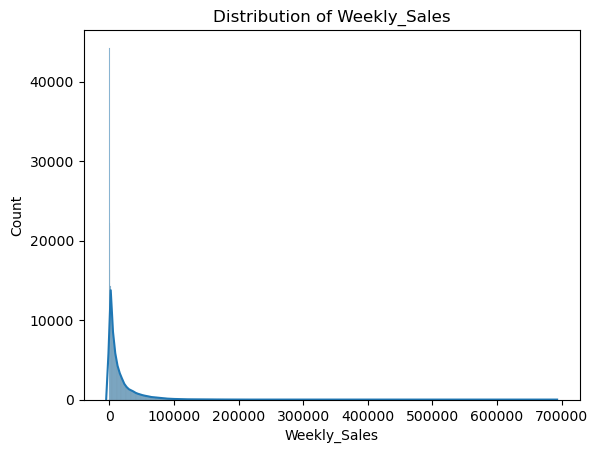

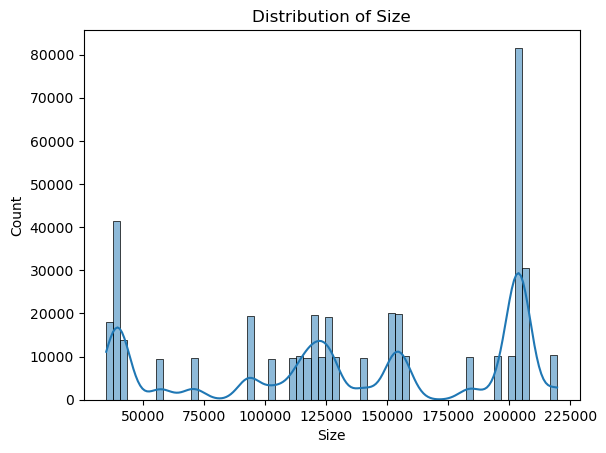

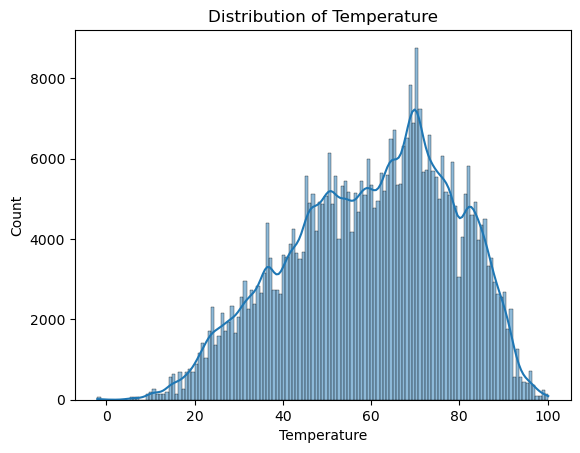

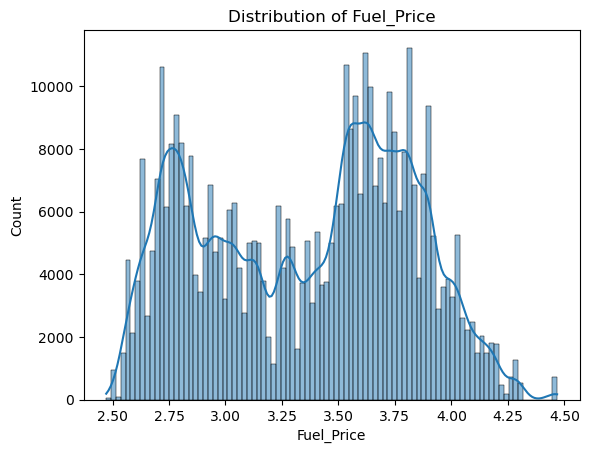

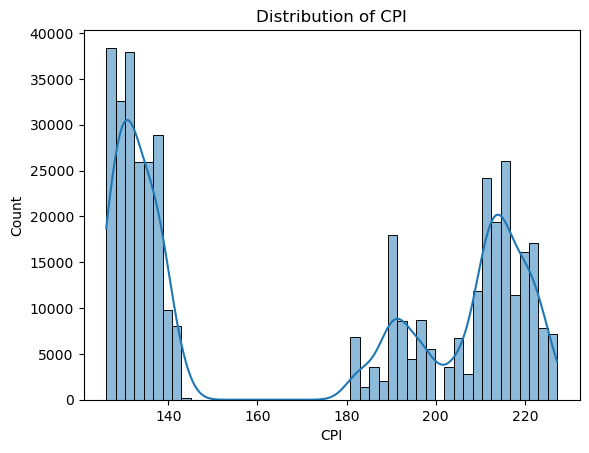

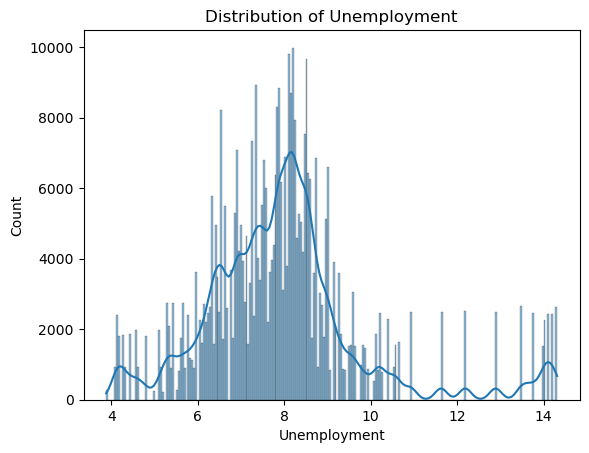

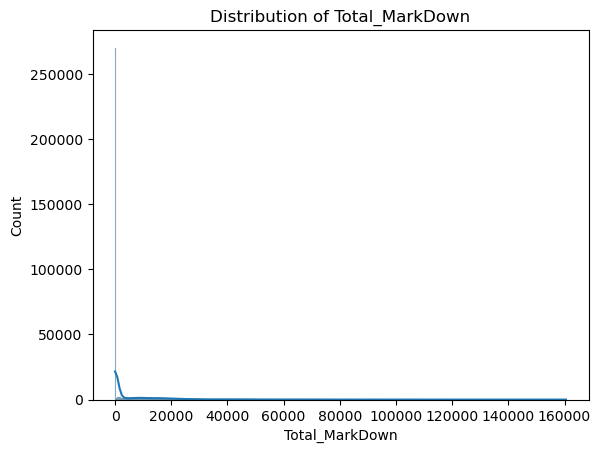

In [ ]:
for col in data_numeric.columns:
    plt.figure()
    sns.histplot(data_numeric[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

Neg weekly sales values

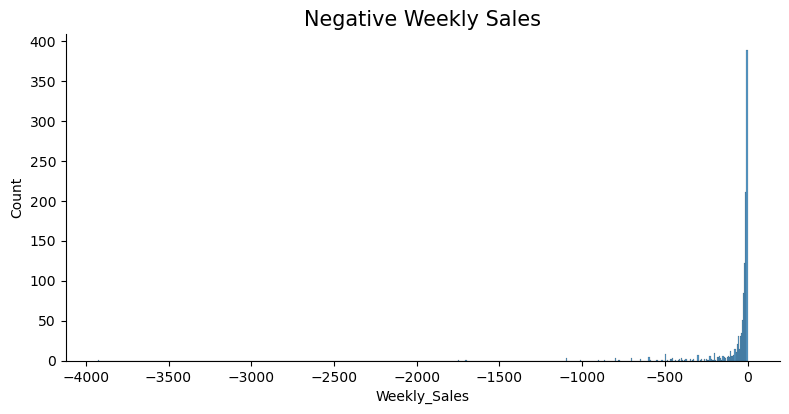

In [ ]:
y = data["Weekly_Sales"][data.Weekly_Sales < 0]
sns.displot(y, height=4, aspect=2)
plt.title("Negative Weekly Sales", fontsize=15)
#plt.savefig("plots/negative_weekly_sales.png")
plt.show()

In [ ]:
data = data[data["Weekly_Sales"] >= 0]

In [ ]:
data.shape

(374247, 20)

In [ ]:
# # Holiday analysis
# holiday = {6:"Super Bowl", 36:"Labor day", 47:"Thanksgiving", 51:"Christmas"}

# #sales average by holiday
# holidays = preprocessed_data[preprocessed_data["Week"].isin([6,36,47,51])]
# holiday_mean = holidays[["Weekly_Sales", "Week"]].groupby("Week").mean().reset_index().sort_values('Weekly_Sales', ascending=False)
# holiday_mean = holiday_mean.rename(columns={"Week":"Holiday"})
# holiday_mean["Holiday"] = holiday_mean["Holiday"].map(holiday)
# holiday_mean

In [ ]:
# fig = px.bar(holiday_mean, x="Holiday", y="Weekly_Sales", 
#              color="Holiday",
#              title = 'Sales average by holiday',
#              template = 'plotly+presentation',
#              text_auto=".2s",
#              color_discrete_sequence = px.colors.qualitative.Pastel)

# fig.update_layout(
#     title={
#         'y':0.92,
#         'x':0.5},
#     font=dict(
#         family='Trebuchet MS',
#         size=15),
#     yaxis_title = 'Sales',
#     xaxis_title = 'Holiday',
# )

# fig.update_traces(textfont_size=14, 
#                   textposition="inside", 
#                   )


# fig.show()


In [ ]:
data["IsHoliday"] = data["IsHoliday"].astype("int")

In [ ]:
data["Date"] = pd.to_datetime(data["Date"])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 374247 entries, 2010-02-05 to 2012-10-26
Data columns (total 20 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Store           374247 non-null  int64         
 1   Dept            374247 non-null  int64         
 2   Date            374247 non-null  datetime64[ns]
 3   Weekly_Sales    374247 non-null  float64       
 4   Type            374247 non-null  object        
 5   Size            374247 non-null  int64         
 6   Temperature     374247 non-null  float64       
 7   Fuel_Price      374247 non-null  float64       
 8   CPI             374247 non-null  float64       
 9   Unemployment    374247 non-null  float64       
 10  IsHoliday       374247 non-null  int32         
 11  Year            374247 non-null  int32         
 12  Month           374247 non-null  int32         
 13  Week            374247 non-null  UInt32        
 14  max             3742

In [ ]:
data

,Store,Dept,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Year,Month,Week,max,min,mean,median,std,Total_MarkDown
Date,,,,,,,,,,,,,,,,,,,,
2010-02-05,1,1,2010-02-05,24924.50,A,151315,42.31,2.572,211.096358,8.106,0,2010,2,5,57592.12,14537.37,22513.322937,18535.480,9854.349032,0.00
2010-02-05,9,97,2010-02-05,668.48,B,125833,38.01,2.572,214.655459,6.415,0,2010,2,5,766.93,-9.92,372.655556,371.050,290.954675,0.00
2010-02-05,9,85,2010-02-05,693.87,B,125833,38.01,2.572,214.655459,6.415,0,2010,2,5,2512.14,110.56,876.629441,824.040,307.436056,0.00
2010-02-05,8,80,2010-02-05,8654.60,A,155078,34.14,2.572,214.471451,6.299,0,2010,2,5,11990.43,7414.43,9188.915105,9161.970,756.223236,0.00
2010-02-05,9,55,2010-02-05,11123.56,B,125833,38.01,2.572,214.655459,6.415,0,2010,2,5,29166.26,4791.74,8607.050490,7571.600,3874.176095,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-10-26,2,26,2012-10-26,9258.88,A,202307,69.79,3.506,223.078337,6.170,0,2012,10,43,19679.04,4179.99,9347.725105,8762.990,2825.107609,9678.80
2012-10-26,38,23,2012-10-26,53.12,C,39690,65.95,4.301,131.193097,10.199,0,2012,10,43,289.78,3.50,37.848679,31.365,34.065601,502.88
2012-10-26,27,6,2012-10-26,5339.65,A,204184,58.99,4.071,142.762411,8.000,0,2012,10,43,41005.33,2524.01,7730.729091,6798.780,5178.928257,10969.27


In [ ]:
data.to_csv("./Resources/preprocessed_data.csv")

Visualizing the data

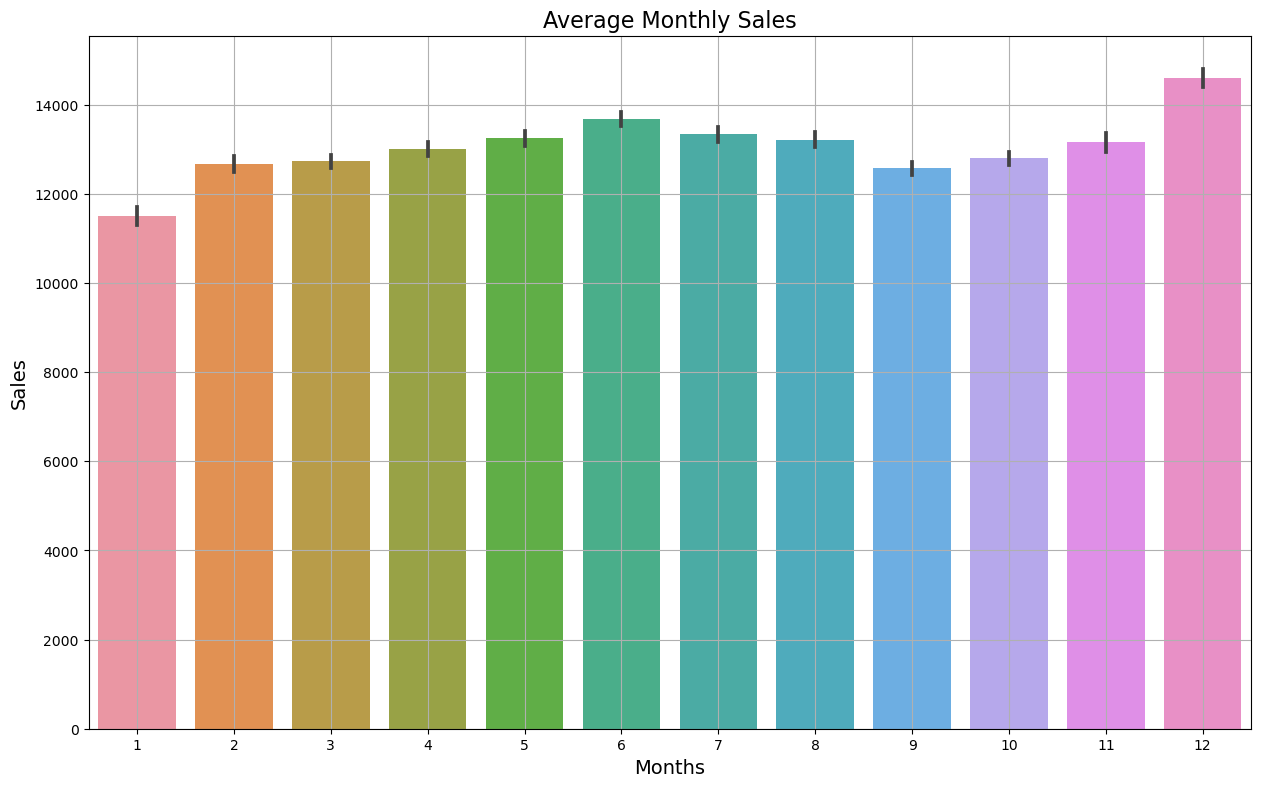

In [ ]:
plt.figure(figsize=(15, 9))
sns.barplot(x="Month", y="Weekly_Sales", data=data)
plt.ylabel("Sales", fontsize=14)
plt.xlabel("Months", fontsize=14)
plt.title("Average Monthly Sales", fontsize=16)
plt.savefig("plots/avg_monthly_sales.png")
plt.grid()

Average monthly sales

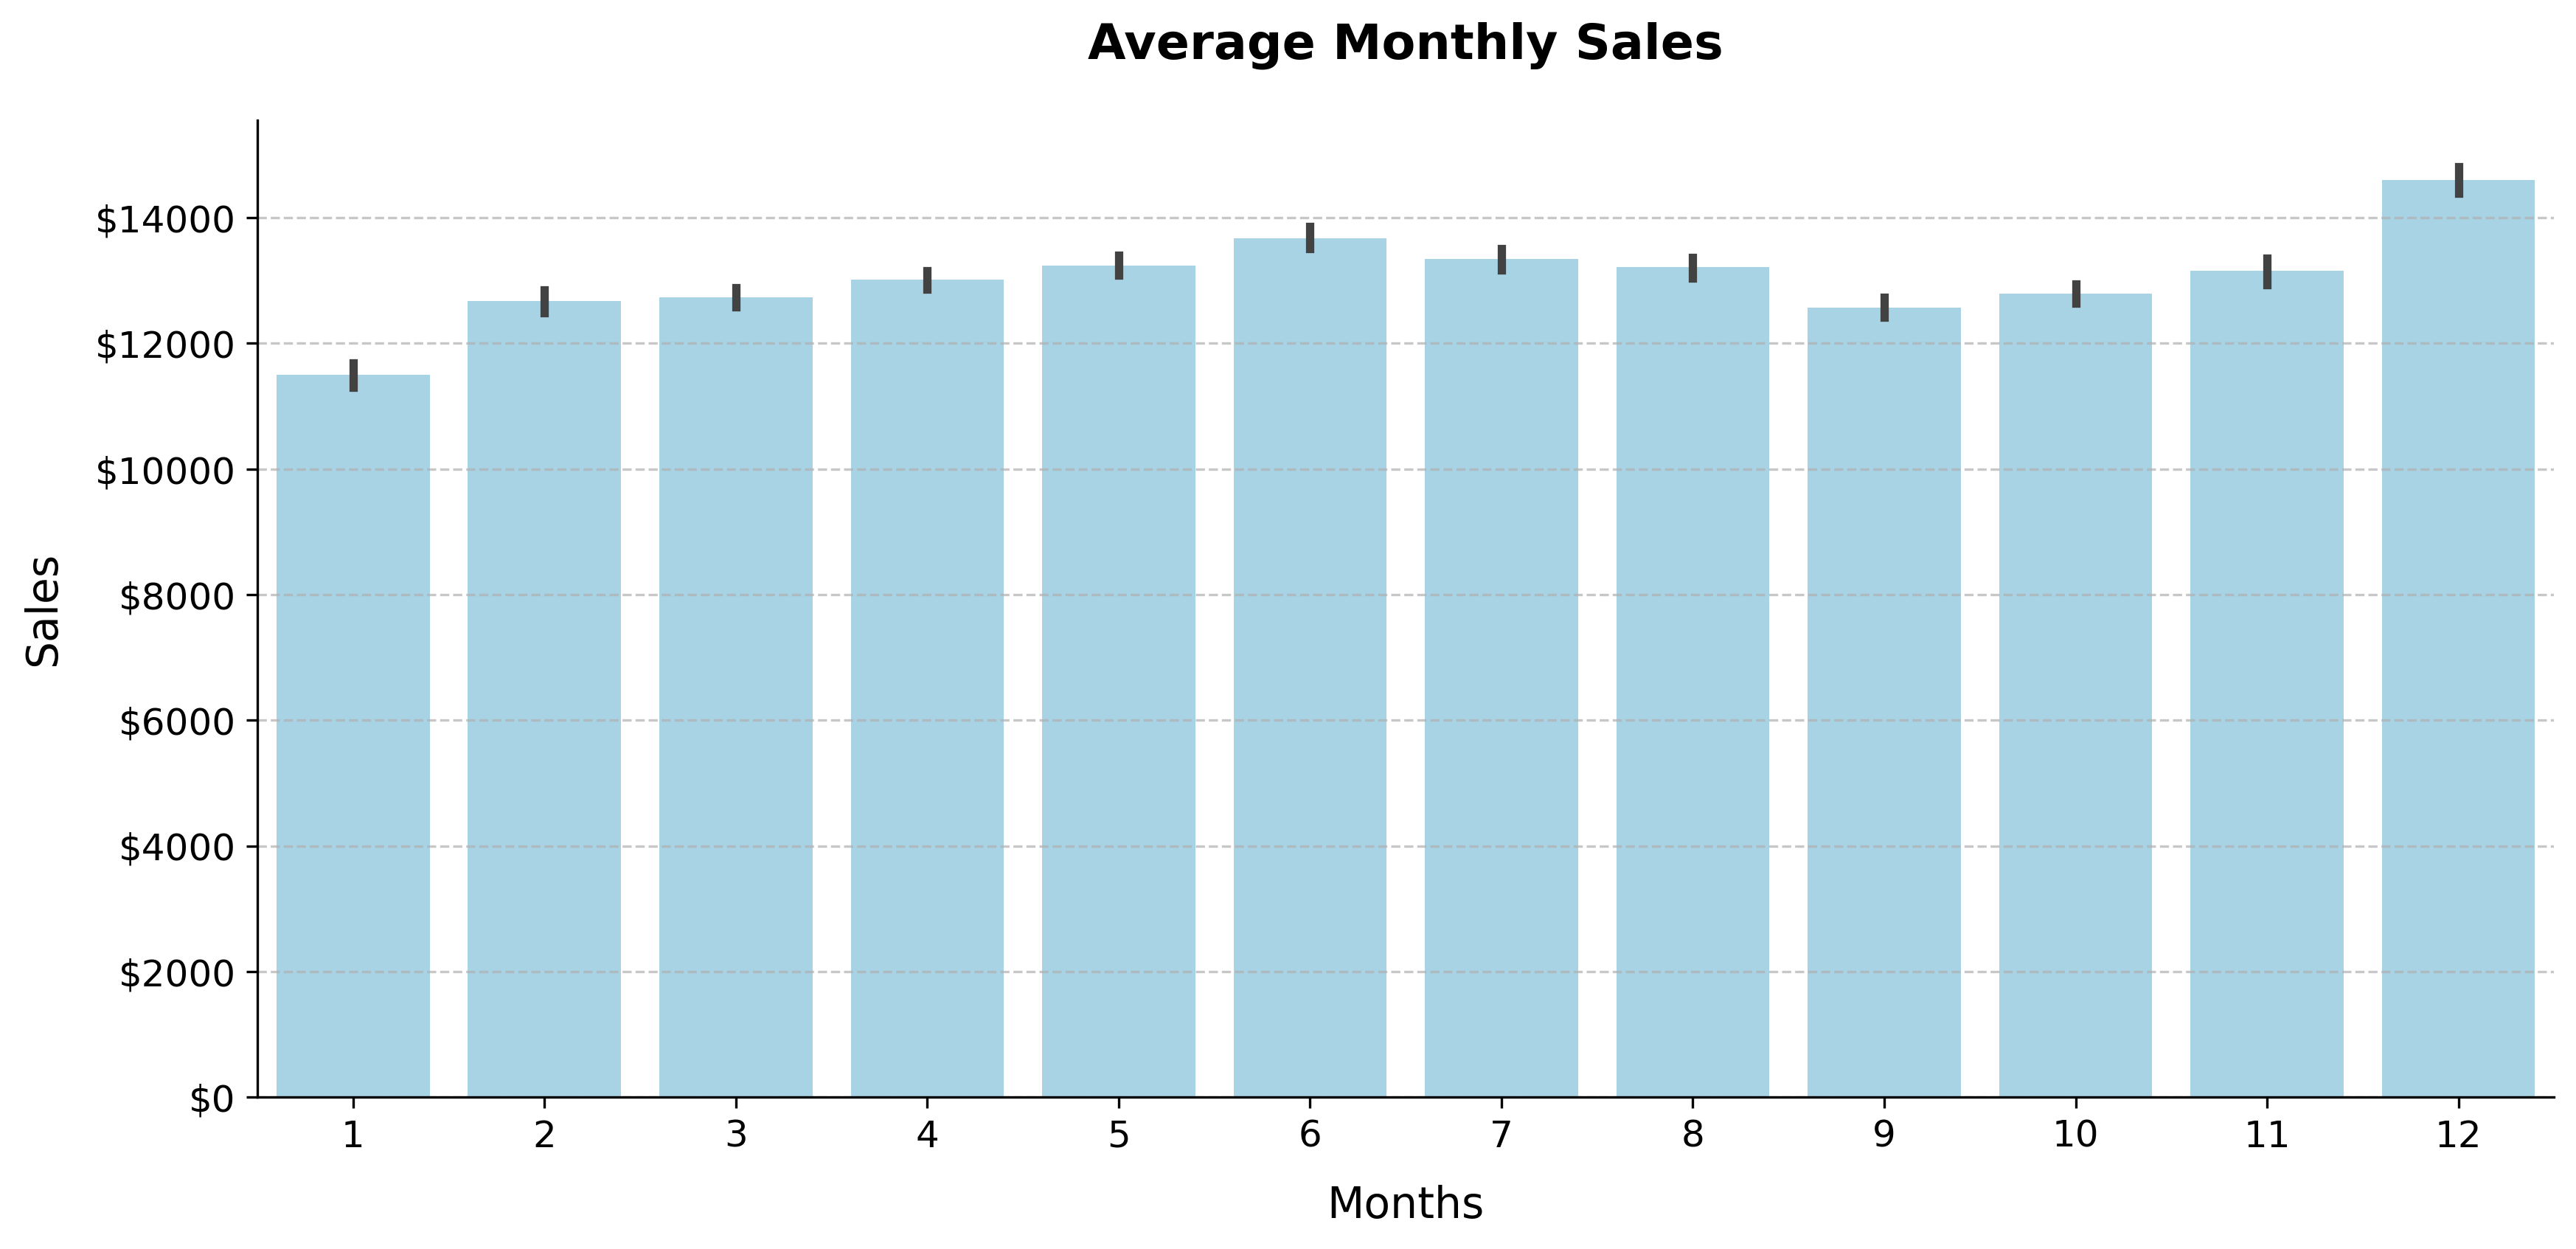

In [ ]:
# Set figure size and resolution
fig, ax = plt.subplots(figsize=(12, 6), dpi=300)

# Create the bar plot using Seaborn
sns.barplot(x="Month", y="Weekly_Sales", data=data, ax=ax, color="skyblue", alpha=0.8)

# Customize the plot
ax.set_title("Average Monthly Sales", fontsize=16, fontweight="bold", pad=20)
ax.set_xlabel("Months", fontsize=14, labelpad=10)
ax.set_ylabel("Sales", fontsize=14, labelpad=10)
ax.tick_params(axis="both", labelsize=12)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: "${:.0f}".format(x)))

# Add grid lines
ax.grid(axis="y", linestyle="--", alpha=0.7)

# Remove top and right spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Adjust layout and spacing
fig.tight_layout(pad=2)

# Save the plot with higher resolution
plt.savefig("plots/avg_monthly_sales.png", dpi=300, bbox_inches="tight")

# Display the plot
plt.show()

Sales by Month for each year.

In [ ]:
# Create the data_monthly DataFrame
data_monthly = pd.crosstab(
    data["Year"], data["Month"], values=data["Weekly_Sales"], aggfunc="sum"
)

# Format the values in data_monthly to include dollar signs and commas
data_monthly_formatted = data_monthly.applymap(lambda x: f"${x:,.2f}")

# Print the title and the formatted DataFrame
print("\nSales by Month for Each Year (in millions):\n")
print(data_monthly_formatted)


Sales by Month for Each Year (in millions):

Month               1                2                3                4   \
Year                                                                        
2010              $nan  $136,598,591.64  $136,997,604.02  $175,325,127.70   
2011   $117,080,880.22  $132,098,712.81  $134,158,585.16  $171,018,127.52   
2012   $117,222,243.41   $89,152,897.32  $173,424,971.15  $147,922,207.83   

Month               5                6                7                8   \
Year                                                                        
2010   $142,267,652.83  $145,576,956.75  $177,695,384.42  $142,617,591.57   
2011   $138,209,726.41  $144,118,163.32  $176,204,577.19  $139,814,321.18   
2012   $151,228,039.98  $190,233,027.28  $145,822,143.63  $163,603,928.43   

Month               9                10               11               12  
Year                                                                       
2010   $134,415,056.17  $168,7

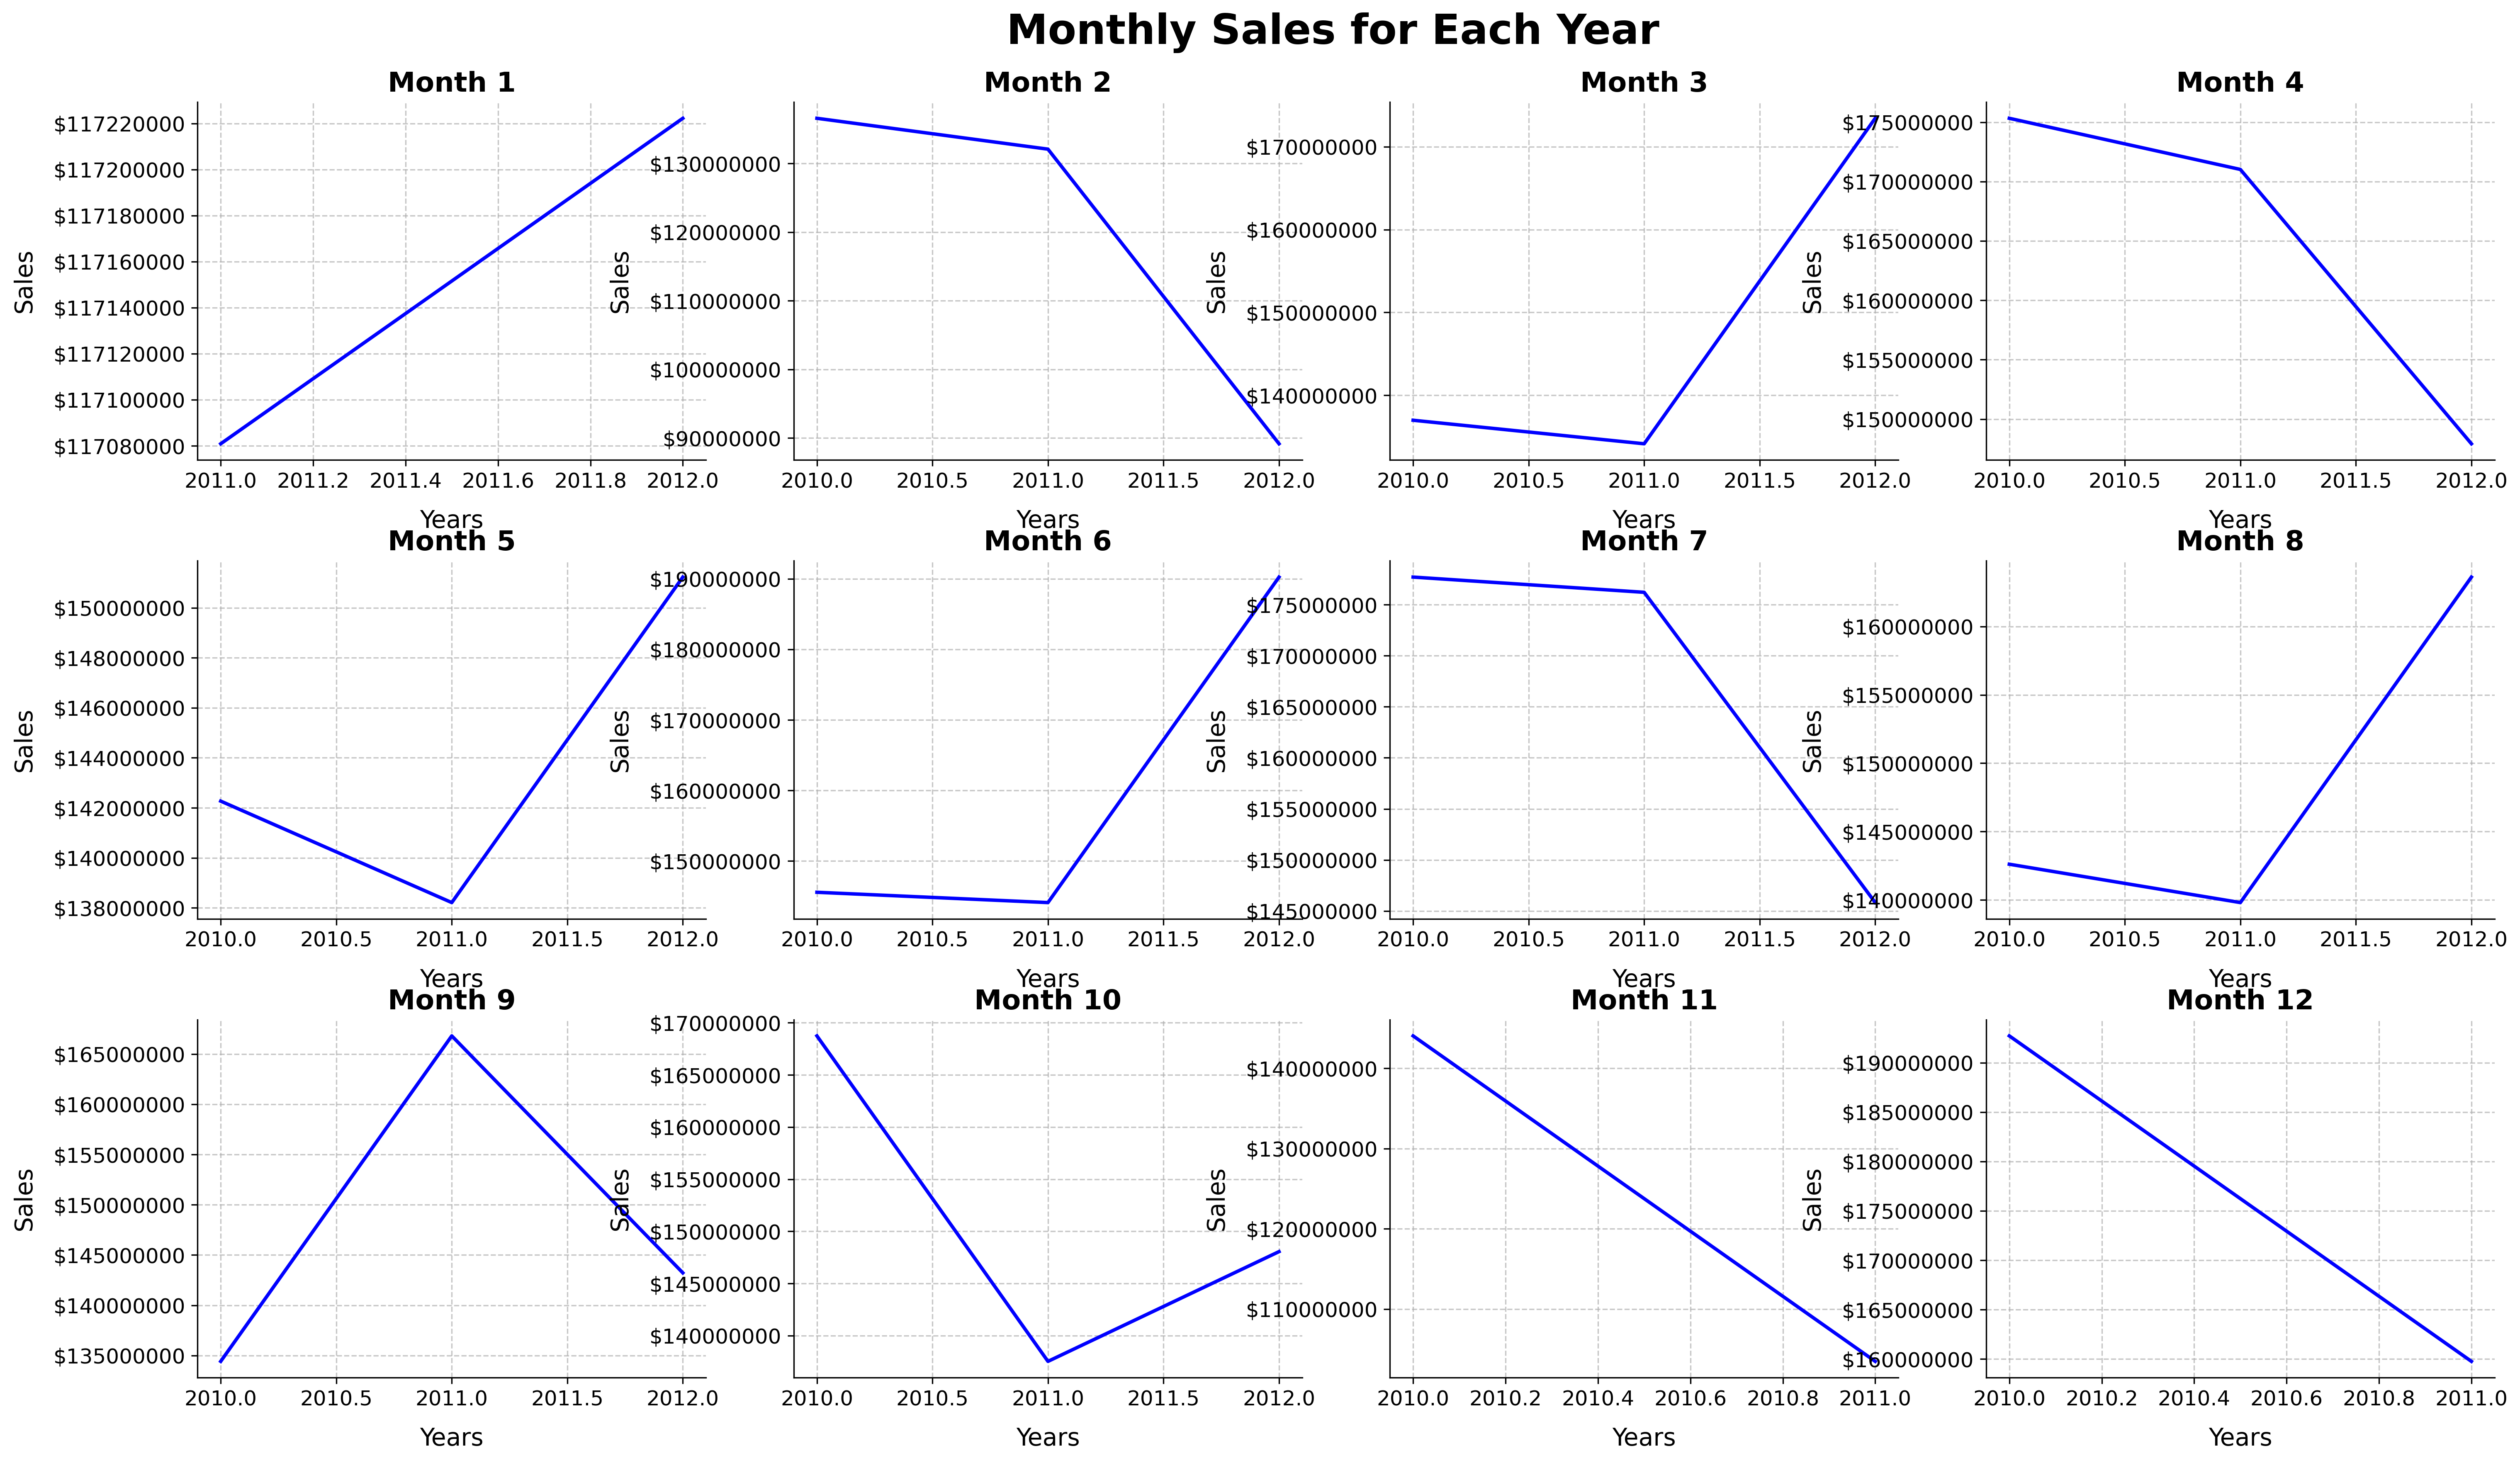

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(20, 12), dpi=300)

# Adjust the layout and spacing
plt.tight_layout(pad=4, w_pad=2, h_pad=4)
plt.subplots_adjust(top=0.92)

# Add a main title for the entire figure
fig.suptitle("Monthly Sales for Each Year", fontsize=24, fontweight="bold")

# Iterate over the subplots and plot the data
for i in range(3):
    for j in range(4):
        k = i * 4 + j + 1

        # Plot the data on the current subplot
        sns.lineplot(data=data_monthly[k], ax=axes[i, j], color="blue", linewidth=2)

        # Set the title for each subplot
        axes[i, j].set_title(f"Month {k}", fontsize=16, fontweight="bold")

        # Set the labels for x-axis and y-axis
        axes[i, j].set_xlabel("Years", fontsize=14, labelpad=10)
        axes[i, j].set_ylabel("Sales", fontsize=14, labelpad=10)

        # Set the tick label size
        axes[i, j].tick_params(axis="both", labelsize=12)

        # Format the y-axis tick labels as currency
        axes[i, j].yaxis.set_major_formatter(
            plt.FuncFormatter(lambda x, pos: "${:.0f}".format(x))
        )

        # Add grid lines
        axes[i, j].grid(linestyle="--", alpha=0.7)

        # Remove top and right spines
        axes[i, j].spines["top"].set_visible(False)
        axes[i, j].spines["right"].set_visible(False)

# Save the plot with higher resolution
plt.savefig("plots/monthly_sales_every_year.png", dpi=300, bbox_inches="tight")

# Display the plot
plt.show()

Avg Weekly Sales by Store 

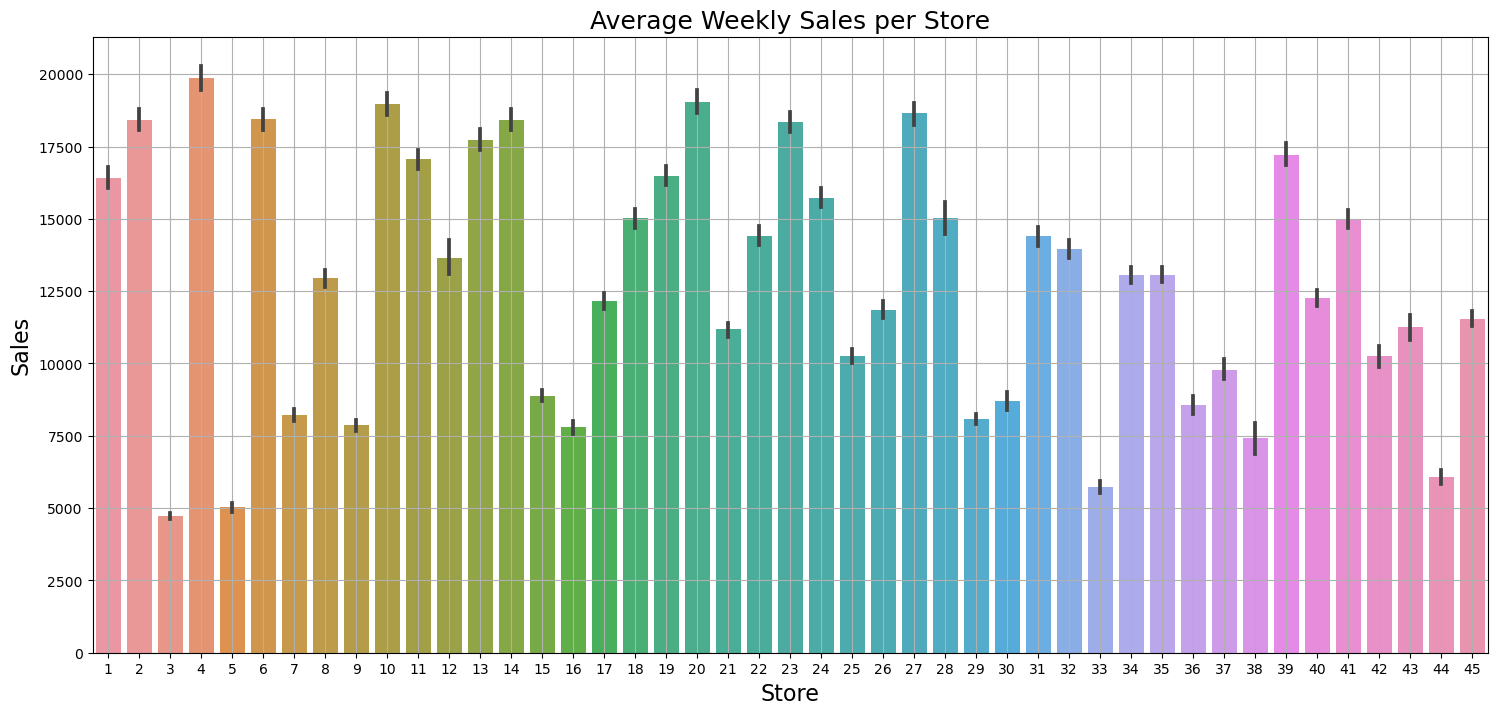

In [ ]:
plt.figure(figsize=(18, 8))
sns.barplot(x="Store", y="Weekly_Sales", data=data)
plt.grid()
plt.title("Average Weekly Sales per Store", fontsize=18)
plt.ylabel("Sales", fontsize=16)
plt.xlabel("Store", fontsize=16)
plt.savefig("plots/avg_sales_store.png")
plt.show()

Top 5 Stores with the Highest Sales:
Store 4.0: $19857.10
Store 20.0: $19037.85
Store 10.0: $18959.31
Store 27.0: $18644.09
Store 6.0: $18440.71


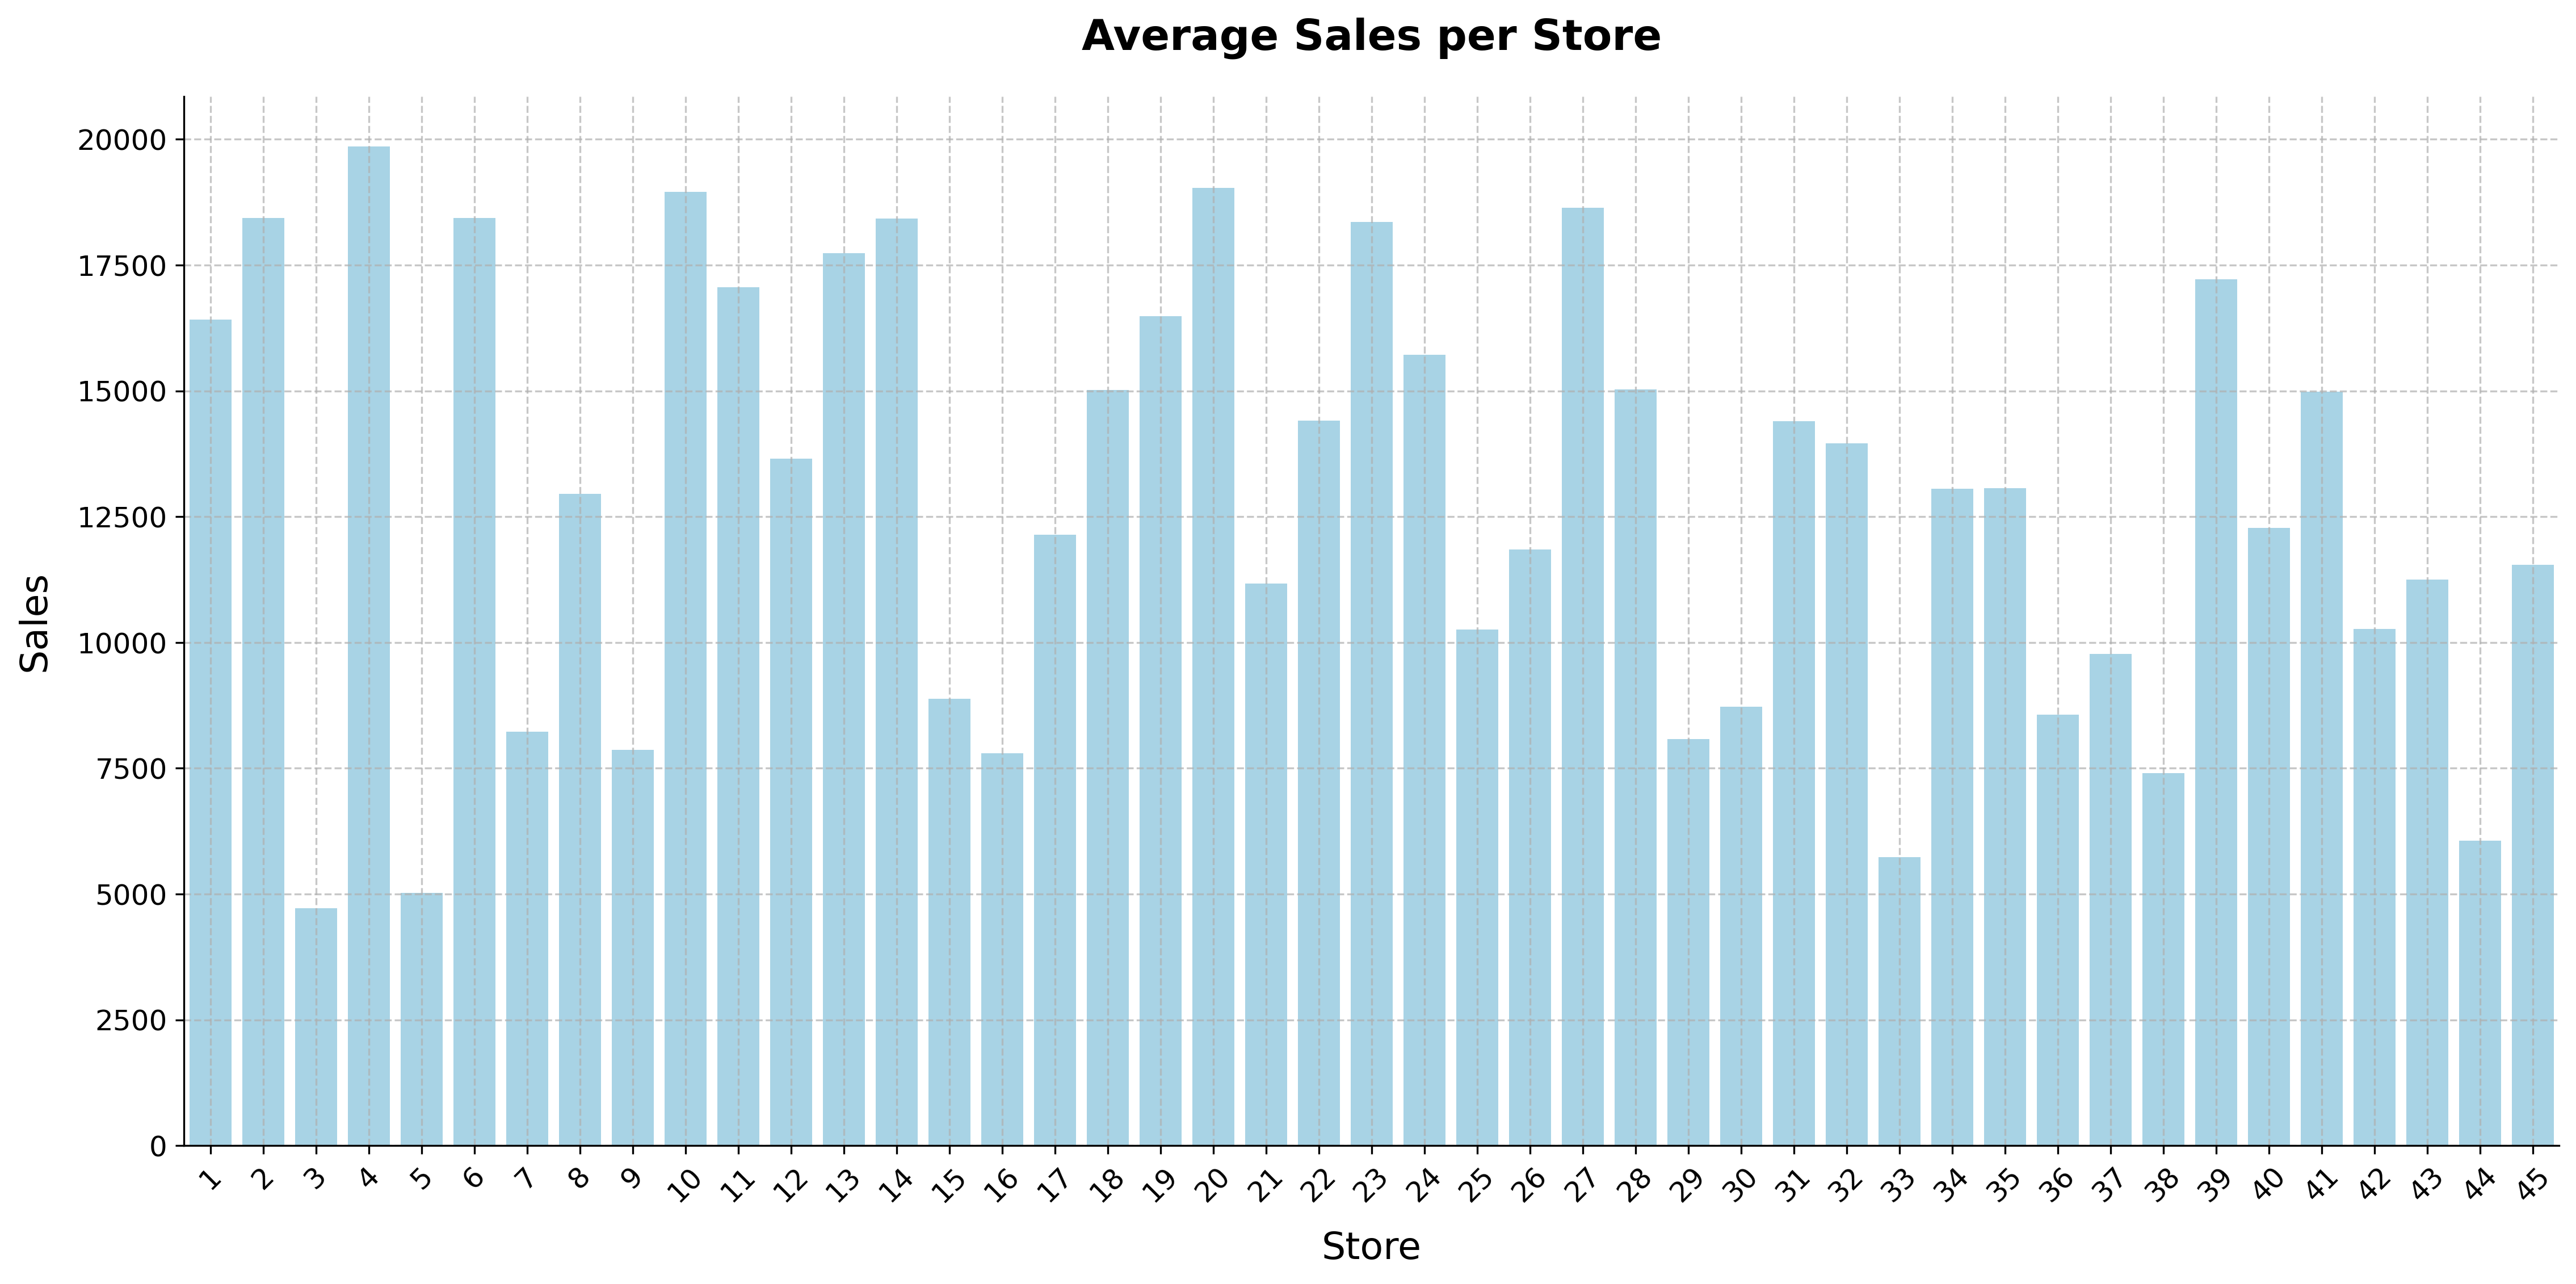

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the average sales per store
avg_sales_per_store = data.groupby("Store")["Weekly_Sales"].mean().reset_index()

# Sort the stores by average sales in descending order
avg_sales_per_store_sorted = avg_sales_per_store.sort_values(
    "Weekly_Sales", ascending=False
)

# Get the top 5 stores with the highest sales
top_5_stores = avg_sales_per_store_sorted.head(5)

# Print the top 5 stores with the highest sales
print("Top 5 Stores with the Highest Sales:")
for index, row in top_5_stores.iterrows():
    store = row["Store"]
    sales = row["Weekly_Sales"]
    print(f"Store {store}: ${sales:.2f}")

# Set figure size and resolution
plt.figure(figsize=(18, 8), dpi=300)

# Create the bar plot
sns.barplot(
    x="Store",
    y="Weekly_Sales",
    data=avg_sales_per_store_sorted,
    color="skyblue",
    alpha=0.8,
)

# Customize the plot
plt.title("Average Sales per Store", fontsize=18, fontweight="bold", pad=20)
plt.xlabel("Store", fontsize=16, labelpad=10)
plt.ylabel("Sales", fontsize=16, labelpad=10)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(linestyle="--", alpha=0.7)

# # Add data labels on top of each bar
# for i, v in enumerate(avg_sales_per_store_sorted["Weekly_Sales"]):
#     plt.text(i, v + 1000, f"${v:.2f}", fontsize=10, ha="center")

# Remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Save the plot with higher resolution
plt.savefig("plots/avg_sales_store.png", dpi=300, bbox_inches="tight")

# Display the plot
plt.show()

Avg sales by department

In [ ]:
# # Create the "Plots" directory if it doesn't exist
# if not os.path.exists("Plots"):
#     os.makedirs("Plots")

# # Save the plot with the correct file path
# plt.savefig("Plots/avg_sales_dept.png")
# plt.show()

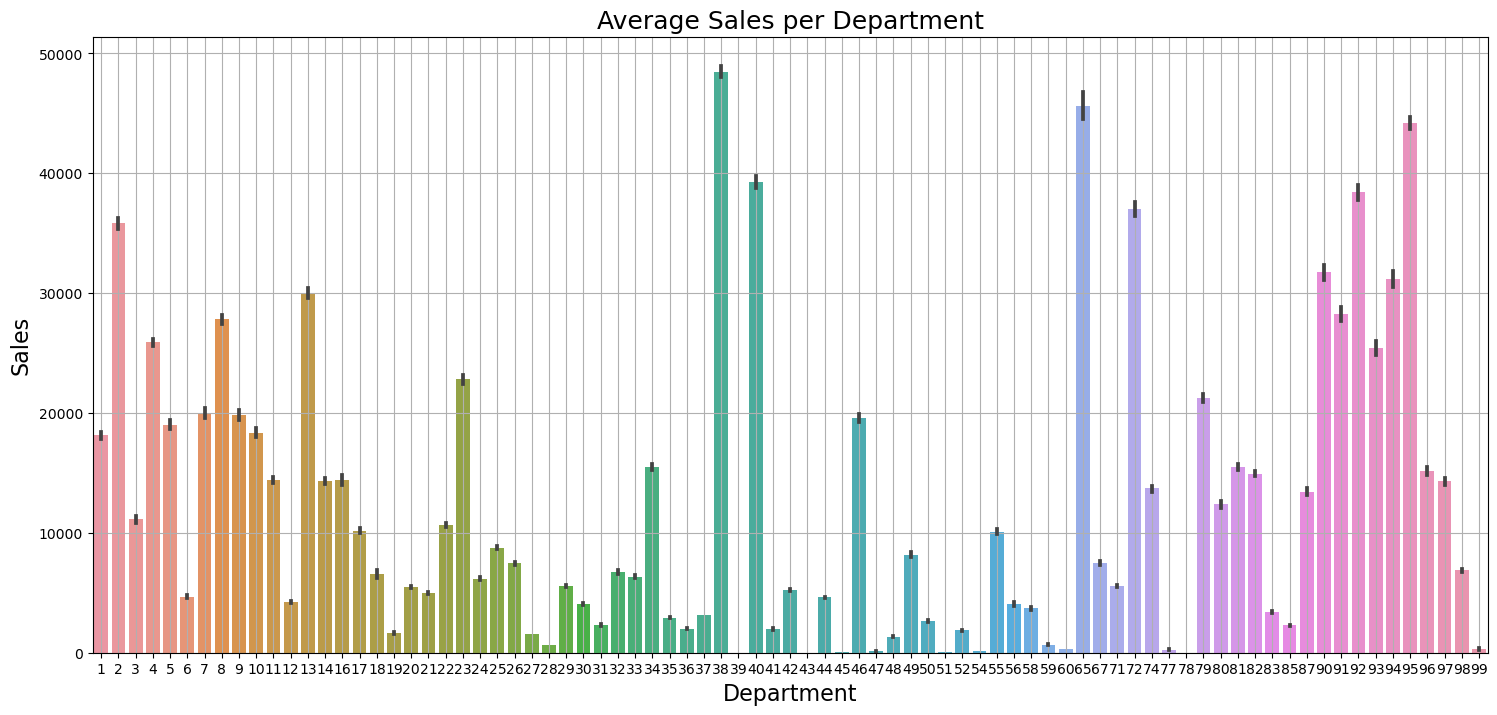

In [ ]:
plt.figure(figsize=(18, 8))
sns.barplot(x="Dept", y="Weekly_Sales", data=data)
plt.grid()
plt.title("Average Sales per Department", fontsize=18)
plt.ylabel("Sales", fontsize=16)
plt.xlabel("Department", fontsize=16)
plt.savefig("Plots/avg_sales_dept.png")
plt.show()

Sales vs Temp

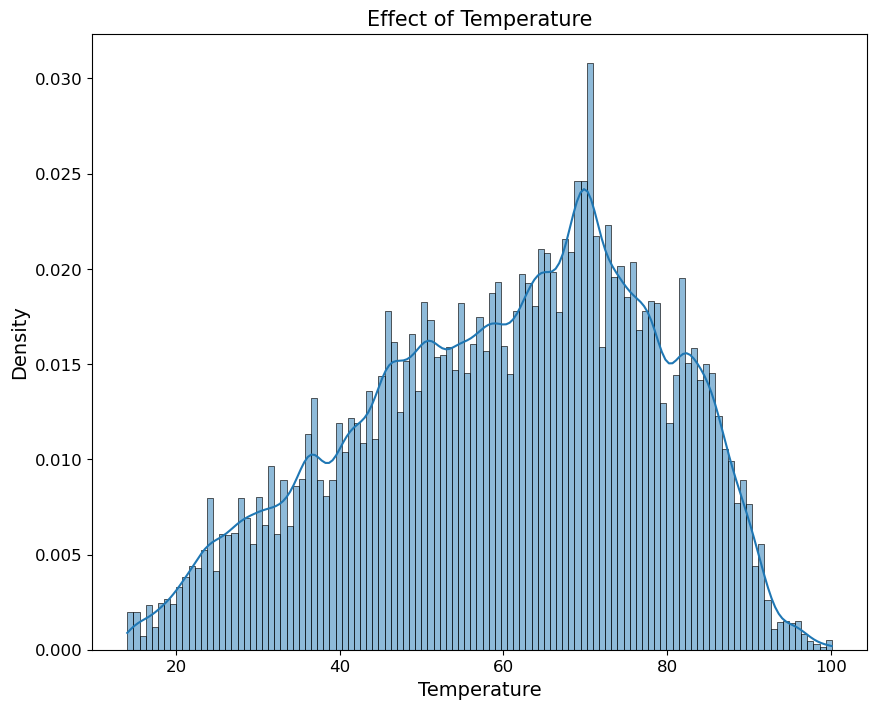

In [ ]:
plt.figure(figsize=(10, 8))
sns.histplot(data=data, x="Temperature", kde=True, stat="density")
plt.title("Effect of Temperature", fontsize=15)
plt.xlabel("Temperature", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.savefig("plots/effect_of_temp.png")
plt.show()

Showing Holiday sales vs Non-Holiday sales

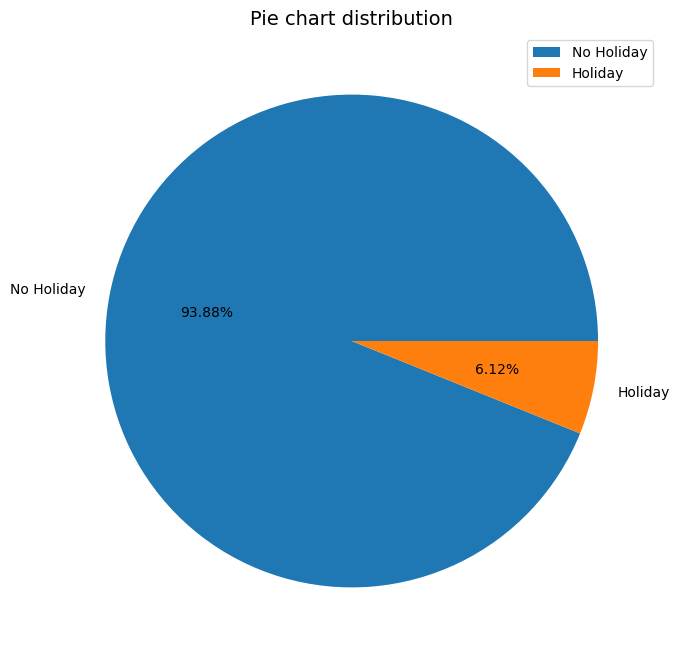

In [ ]:
plt.figure(figsize=(8, 8))
plt.pie(
    data["IsHoliday"].value_counts(),
    labels=["No Holiday", "Holiday"],
    autopct="%0.2f%%",
)
plt.title("Pie chart distribution", fontsize=14)
plt.legend()
#plt.savefig("plots/holiday_distribution.png")
plt.show()

Time Series Decomposition- This function is used for time series decomposition, which means breaking down a time series into its underlying components such as trend, seasonality, and residual.  The model="additive". This specifies the decomposition model to be used. In this case, the "additive" model is chosen, which assumes that the observed time series is the sum of the trend, seasonality, and residual components.

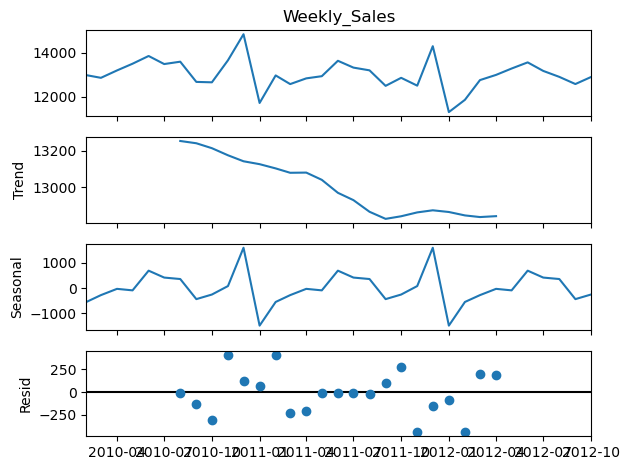

In [ ]:
sm.tsa.seasonal_decompose(
    data["Weekly_Sales"].resample("MS").mean(), model="additive"
).plot()
plt.savefig("plots/seasonal_decompose.png")
plt.show()

Explanation and notes:

The code starts by resampling the "Weekly_Sales" data to a monthly frequency using resample("MS") and calculates the mean sales for each month using mean(). This step aggregates the weekly sales data into monthly sales data.
The seasonal_decompose function from the statsmodels library is used to perform seasonal decomposition on the monthly sales data. The model parameter is set to "additive", indicating that the components are assumed to be added together to form the observed data.
The decomposition components are extracted: trend, seasonal, and residual.

The trend component represents the long-term pattern or trend in the data.
The seasonal component captures the repeating patterns or seasonality in the data.
The residual component represents the remaining part of the data after removing the trend and seasonal components.


A figure with four subplots is created using plt.subplots(4, 1, figsize=(10, 12), sharex=True). The figsize parameter sets the size of the figure, and sharex=True ensures that the x-axis is shared among the subplots.
The original monthly sales data is plotted in the first subplot using axs[0].plot(monthly_sales). This subplot shows the actual observed sales data.
The trend component is plotted in the second subplot using axs[1].plot(trend). This subplot visualizes the long-term trend in the sales data.
The seasonal component is plotted in the third subplot using axs[2].plot(seasonal). This subplot shows the repeating patterns or seasonality present in the sales data.
The residual component is plotted in the fourth subplot using axs[3].plot(residual). This subplot represents the remaining part of the sales data after removing the trend and seasonal components.
The spacing between the subplots is adjusted using plt.tight_layout() to ensure proper spacing and avoid overlapping.
The plot is saved as "plots/seasonal_decompose.png" using plt.savefig().
Finally, the plot is displayed using plt.show().

The output of this code will be a plot with four subplots:

The first subplot shows the original monthly sales data.
The second subplot displays the trend component, representing the long-term pattern in the sales data.
The third subplot shows the seasonal component, capturing the repeating patterns or seasonality in the sales data.
The fourth subplot represents the residual component, which is the remaining part of the sales data after removing the trend and seasonal components.

This decomposition plot helps in understanding the underlying components of the sales data and how they contribute to the overall observed pattern. It can provide insights into the long-term trend, seasonal variations, and any remaining unexplained fluctuations in the sales data.

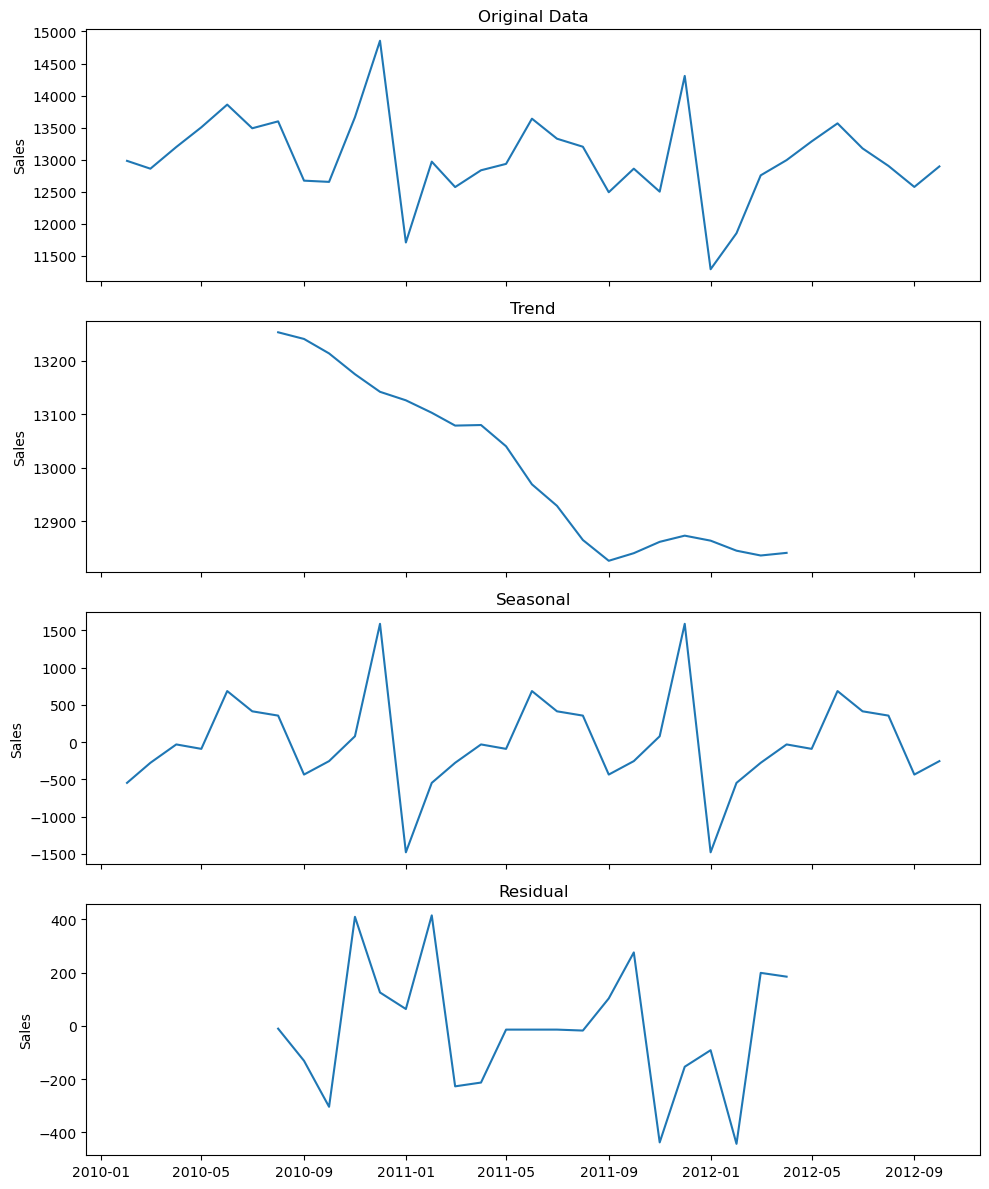

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Resample the data to monthly frequency and calculate the mean sales
monthly_sales = data["Weekly_Sales"].resample("MS").mean()

# Perform seasonal decomposition
decomposition = seasonal_decompose(monthly_sales, model="additive")

# Extract the components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Create a figure with four subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

# Plot the original data
axs[0].plot(monthly_sales)
axs[0].set_title("Original Data")
axs[0].set_ylabel("Sales")

# Plot the trend component
axs[1].plot(trend)
axs[1].set_title("Trend")
axs[1].set_ylabel("Sales")

# Plot the seasonal component
axs[2].plot(seasonal)
axs[2].set_title("Seasonal")
axs[2].set_ylabel("Sales")

# Plot the residual component
axs[3].plot(residual)
axs[3].set_title("Residual")
axs[3].set_ylabel("Sales")

# Adjust the spacing between subplots
plt.tight_layout()

# Save the plot
plt.savefig("plots/seasonal_decompose.png")

# Show the plot
plt.show()

Using one hot encoding to convert categorical data to numerical data

In [ ]:
data.info()



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 374247 entries, 2010-02-05 to 2012-10-26
Data columns (total 20 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Store           374247 non-null  int64         
 1   Dept            374247 non-null  int64         
 2   Date            374247 non-null  datetime64[ns]
 3   Weekly_Sales    374247 non-null  float64       
 4   Type            374247 non-null  object        
 5   Size            374247 non-null  int64         
 6   Temperature     374247 non-null  float64       
 7   Fuel_Price      374247 non-null  float64       
 8   CPI             374247 non-null  float64       
 9   Unemployment    374247 non-null  float64       
 10  IsHoliday       374247 non-null  int32         
 11  Year            374247 non-null  int32         
 12  Month           374247 non-null  int32         
 13  Week            374247 non-null  UInt32        
 14  max             3742

Category colums are Store, Dept and Type.

In [ ]:
cat_col = ["Store", "Dept", "Type"]
data_cat = data[cat_col].copy()

In [ ]:
data_cat.tail()

,Store,Dept,Type
Date,,,
2012-10-26,2,26,A
2012-10-26,38,23,C
2012-10-26,27,6,A
2012-10-26,36,40,A
2012-10-26,45,98,B


In [ ]:

data_cat = pd.get_dummies(data_cat, columns=cat_col, dtype=int)

data_cat.head()

,Store_1,Store_2,Store_3,Store_4,Store_5,Store_6,Store_7,Store_8,Store_9,Store_10,...,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99,Type_A,Type_B,Type_C
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2010-02-05,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
2010-02-05,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2010-02-05,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2010-02-05,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
data.shape

(374247, 20)

In [ ]:
data = pd.concat([data, data_cat], axis=1)

In [ ]:
data.drop(columns=cat_col, inplace=True)

In [ ]:
data.drop(columns=["Date"], inplace=True)

Normalizing the data

In [ ]:
num_col = [
    "Weekly_Sales",
    "Size",
    "Temperature",
    "Fuel_Price",
    "CPI",
    "Unemployment",
    "Total_MarkDown",
    "max",
    "min",
    "mean",
    "median",
    "std",
]

In [ ]:
data.head()

,Weekly_Sales,Size,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Year,Month,Week,...,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99,Type_A,Type_B,Type_C
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,24924.50,151315,42.31,2.572,211.096358,8.106,0,2010,2,5,...,0,0,0,0,0,0,0,1,0,0
2010-02-05,668.48,125833,38.01,2.572,214.655459,6.415,0,2010,2,5,...,0,0,0,0,1,0,0,0,1,0
2010-02-05,693.87,125833,38.01,2.572,214.655459,6.415,0,2010,2,5,...,0,0,0,0,0,0,0,0,1,0
2010-02-05,8654.60,155078,34.14,2.572,214.471451,6.299,0,2010,2,5,...,0,0,0,0,0,0,0,1,0,0
2010-02-05,11123.56,125833,38.01,2.572,214.655459,6.415,0,2010,2,5,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
minmax_scale = MinMaxScaler(feature_range=(0, 1))
def normalization(df, col):
    for i in col:
        arr = df[i]
        arr = np.array(arr)
        df[i] = minmax_scale.fit_transform(arr.reshape(len(arr), 1))
    return df

In [ ]:
data = normalization(data.copy(), num_col)

In [ ]:
data.head()

,Weekly_Sales,Size,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Year,Month,Week,...,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99,Type_A,Type_B,Type_C
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,0.342576,0.630267,0.328495,0.0501,0.840500,0.508787,0,2010,2,5,...,0,0,0,0,0,0,0,1,0,0
2010-02-05,0.009188,0.492338,0.278565,0.0501,0.875680,0.305248,0,2010,2,5,...,0,0,0,0,1,0,0,0,1,0
2010-02-05,0.009537,0.492338,0.278565,0.0501,0.875680,0.305248,0,2010,2,5,...,0,0,0,0,0,0,0,0,1,0
2010-02-05,0.118953,0.650636,0.233627,0.0501,0.873861,0.291286,0,2010,2,5,...,0,0,0,0,0,0,0,1,0,0
2010-02-05,0.152888,0.492338,0.278565,0.0501,0.875680,0.305248,0,2010,2,5,...,0,0,0,0,0,0,0,0,1,0


Examing the correlation between the features

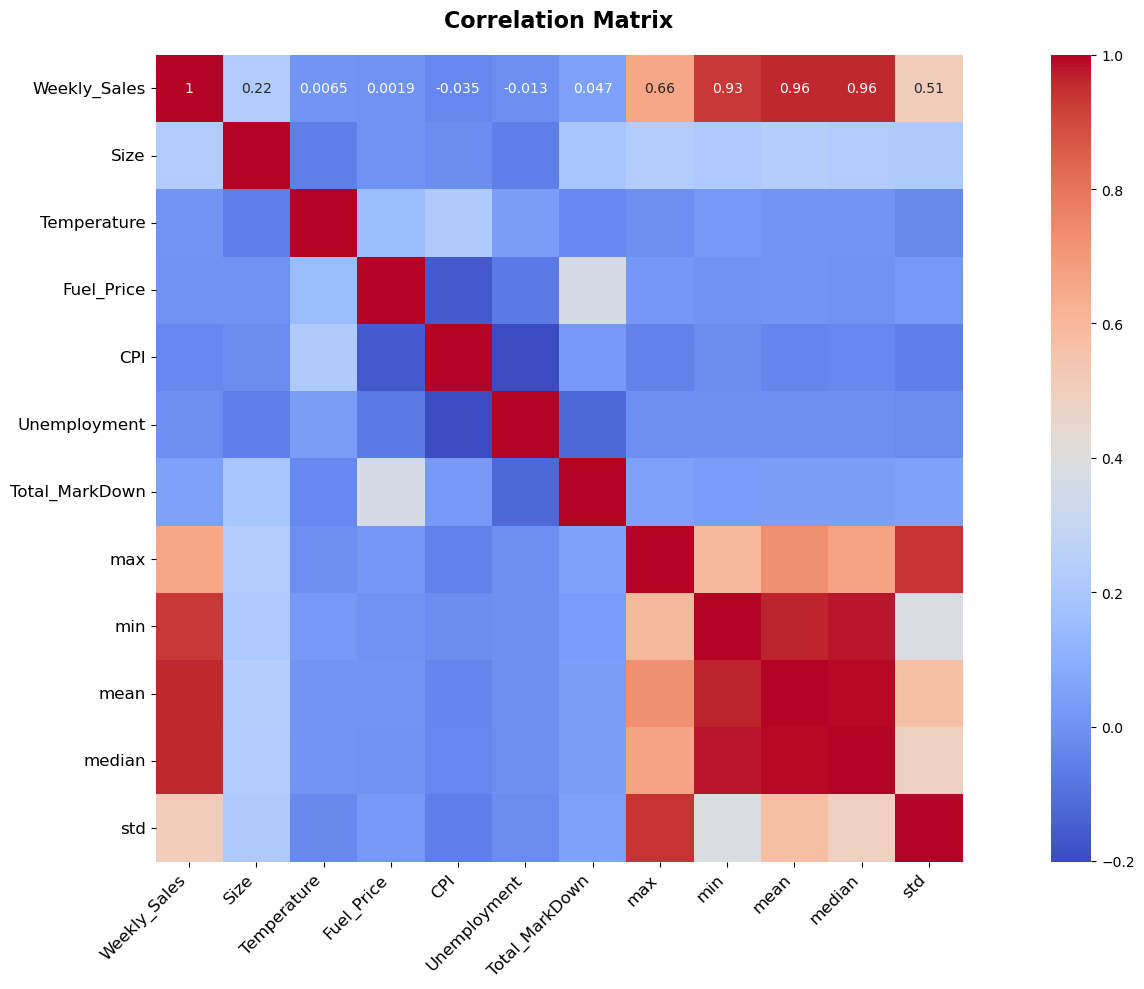

,Weekly_Sales,Size,Temperature,Fuel_Price,CPI,Unemployment,Total_MarkDown,max,min,mean,median,std
Weekly_Sales,1.00,0.22,0.01,0.00,-0.03,-0.01,0.05,0.66,0.93,0.96,0.96,0.51
Size,0.22,1.00,-0.06,-0.00,-0.01,-0.06,0.19,0.23,0.21,0.24,0.22,0.22
Temperature,0.01,-0.06,1.00,0.15,0.22,0.03,-0.03,-0.01,0.02,0.01,0.01,-0.03
Fuel_Price,0.00,-0.00,0.15,1.00,-0.16,-0.07,0.36,0.02,-0.00,0.01,0.00,0.02
CPI,-0.03,-0.01,0.22,-0.16,1.00,-0.20,0.02,-0.05,-0.02,-0.04,-0.03,-0.06
Unemployment,-0.01,-0.06,0.03,-0.07,-0.20,1.00,-0.12,-0.01,-0.01,-0.01,-0.01,-0.02
Total_MarkDown,0.05,0.19,-0.03,0.36,0.02,-0.12,1.00,0.05,0.03,0.04,0.04,0.05
max,0.66,0.23,-0.01,0.02,-0.05,-0.01,0.05,1.00,0.59,0.73,0.67,0.94
min,0.93,0.21,0.02,-0.00,-0.02,-0.01,0.03,0.59,1.00,0.97,0.98,0.38
mean,0.96,0.24,0.01,0.01,-0.04,-0.01,0.04,0.73,0.97,1.00,0.99,0.57


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr = data[num_col].corr()


fig, ax = plt.subplots(figsize=(18, 10))

# Create a heatmap of the correlation matrix
sns.heatmap(corr, vmax=1.0, annot=True, cmap="coolwarm", square=True, ax=ax)
cmap = sns.color_palette("colorblind", as_cmap=True)

plt.title("Correlation Matrix", fontsize=16, fontweight="bold", pad=20)
plt.xticks(fontsize=12, rotation=45, ha="right")
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()

# Save the plot
plt.savefig("plots/correlation_matrix_heatmap.png", dpi=300, bbox_inches="tight")

# Display the plot
plt.show()

# Set the threshold for multicollinearity
threshold = 0.7

# Create a styled table of the correlation matrix
styled_corr = (
    corr.style.background_gradient(cmap="coolwarm", axis=None)
    .format("{:.2f}")
    .applymap(
        lambda x: "background-color: green" if abs(x) > threshold and x != 1.0 else ""
    )
)

# Display the styled table, this was added for the colorblind person in the group.  The table is easier to read.
display(styled_corr)

# Save the styled table as an image
# dfi.export(styled_corr, "plots/correlation_matrix_table.png")

Recursive Feature Elimination

In [ ]:
feature_col = data.columns.difference(['Weekly_Sales'])
feature_col

Index(['CPI', 'Dept_1', 'Dept_10', 'Dept_11', 'Dept_12', 'Dept_13', 'Dept_14',
       'Dept_16', 'Dept_17', 'Dept_18',
       ...
       'Type_B', 'Type_C', 'Unemployment', 'Week', 'Year', 'max', 'mean',
       'median', 'min', 'std'],
      dtype='object', length=144)

In [ ]:
radm_clf = RandomForestRegressor(oob_score=True, n_estimators=23)
radm_clf.fit(data[feature_col], data["Weekly_Sales"])

RandomForestRegressor(n_estimators=23, oob_score=True)

This line creates an empty DataFrame called feature_rank with three columns: "rank", "feature", and "importance".

In [ ]:
indices = np.argsort(radm_clf.feature_importances_)[::-1]
feature_rank = pd.DataFrame(columns=["rank", "feature", "importance"])

for f in range(data[feature_col].shape[1]):
    feature_rank.loc[f] = [
        f + 1,
        data[feature_col].columns[indices[f]],
        radm_clf.feature_importances_[indices[f]],
    ]

feature_rank

,rank,feature,importance
0,1,median,5.237360e-01
1,2,mean,4.040576e-01
2,3,Week,1.991898e-02
3,4,Temperature,8.837763e-03
4,5,CPI,5.921865e-03
...,...,...,...
139,140,Dept_51,2.882920e-10
140,141,Dept_45,2.629473e-10
141,142,Dept_78,3.912596e-12
142,143,Dept_39,1.896103e-14


In [ ]:
x = feature_rank.loc[0:22, ["feature"]]
x = x["feature"].tolist()
print(x)

['median', 'mean', 'Week', 'Temperature', 'CPI', 'max', 'Fuel_Price', 'min', 'std', 'Unemployment', 'Month', 'Total_MarkDown', 'Dept_16', 'Dept_18', 'Dept_3', 'IsHoliday', 'Size', 'Dept_11', 'Year', 'Dept_1', 'Dept_9', 'Dept_5', 'Dept_56']


In [ ]:
X = data[x]
Y = data["Weekly_Sales"]

In [ ]:
data = pd.concat([X, Y], axis=1)

In [ ]:
data

,median,mean,Week,Temperature,CPI,max,Fuel_Price,min,std,Unemployment,...,Dept_3,IsHoliday,Size,Dept_11,Year,Dept_1,Dept_9,Dept_5,Dept_56,Weekly_Sales
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,0.173215,0.208157,5,0.328495,0.840500,0.088635,0.050100,0.253530,0.138276,0.508787,...,0,0,0.630267,0,2010,1,0,0,0,0.342576
2010-02-05,0.004767,0.004499,5,0.278565,0.875680,0.001180,0.050100,0.064648,0.004083,0.305248,...,0,0,0.492338,0,2010,0,0,0,0,0.009188
2010-02-05,0.008968,0.009135,5,0.278565,0.875680,0.003866,0.050100,0.066212,0.004314,0.305248,...,0,0,0.492338,0,2010,0,0,0,0,0.009537
2010-02-05,0.086290,0.085594,5,0.233627,0.873861,0.018453,0.050100,0.161046,0.010611,0.291286,...,0,0,0.650636,0,2010,0,0,0,0,0.118953
2010-02-05,0.071542,0.080242,5,0.278565,0.875680,0.044887,0.050100,0.126993,0.054362,0.305248,...,0,0,0.492338,0,2010,0,0,0,0,0.152888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-10-26,0.082590,0.087055,43,0.647585,0.958935,0.030286,0.518036,0.119050,0.039642,0.275758,...,0,0,0.906277,0,2012,0,0,0,0,0.127259
2012-10-26,0.001617,0.001419,43,0.602996,0.050698,0.000446,0.916333,0.064822,0.000478,0.760713,...,0,0,0.026063,0,2012,0,0,0,0,0.000730
2012-10-26,0.064375,0.072181,43,0.522178,0.165055,0.063107,0.801102,0.097548,0.072670,0.496028,...,0,0,0.916437,0,2012,0,0,0,0,0.073391


Splitting the data into training and testing data

In [ ]:
X = data.drop(["Weekly_Sales"], axis=1)
Y = data.Weekly_Sales

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.20, random_state=50
)

Random Forest Regressor

In [ ]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

In [ ]:
rf_acc = rf.score(X_test, y_test) * 100
print("Random Forest Regressor Accuracy - ", rf_acc)

Random Forest Regressor Accuracy -  97.89999926837496


In [ ]:
y_pred = rf.predict(X_test)

In [ ]:
from sklearn import metrics
print("MAE", metrics.mean_absolute_error(y_test, y_pred))
print("MSE", metrics.mean_squared_error(y_test, y_pred))
print("RMSE", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("R2", metrics.explained_variance_score(y_test, y_pred))

MAE 0.015501594535143342
MSE 0.0009481293903472086
RMSE 0.03079170976654607
R2 0.9790003241296569


In [ ]:
from prettytable import PrettyTable

# Calculate metrics
mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
r2 = metrics.explained_variance_score(y_test, y_pred)

# Create a table
table = PrettyTable()
table.field_names = ["Metric", "Value"]
table.add_row(["MAE", f"{mae:.2f}"])
table.add_row(["MSE", f"{mse:.2f}"])
table.add_row(["RMSE", f"{rmse:.2f}"])
table.add_row(["R2", f"{r2:.2f}"])

# Print the table
print(table)

+--------+-------+
| Metric | Value |
+--------+-------+
|  MAE   |  0.02 |
|  MSE   |  0.00 |
|  RMSE  |  0.03 |
|   R2   |  0.98 |
+--------+-------+


Linear Regression

In [ ]:
print(X_train.shape[0], y_train.shape[0])
print(X_test.shape[0], y_test.shape[0])

299397 299397
74850 74850


In [ ]:
print("Length of X_train: ", len(X_train))
print("Length of y_train: ", len(y_train))
print("Length of X_test: ", len(X_test))
print("Length of y_test: ", len(y_test))

Length of X_train:  299397
Length of y_train:  299397
Length of X_test:  74850
Length of y_test:  74850


In [ ]:
X = data.drop(["Weekly_Sales"], axis=1)
Y = data.Weekly_Sales

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.20, random_state=50
)

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

Predictions: [0.1325547  0.28024189 0.02608487 ... 0.32183861 0.01360682 0.2354347 ]
Mean Absolute Error 0.030057714921514517
Mean Squared Error 0.0034851431916206577
RMSE 0.059035101351828455
R2 0.9228079866096734
Mean Squared Error: 0.0034851431916206577
R-squared: 0.9228079698115758


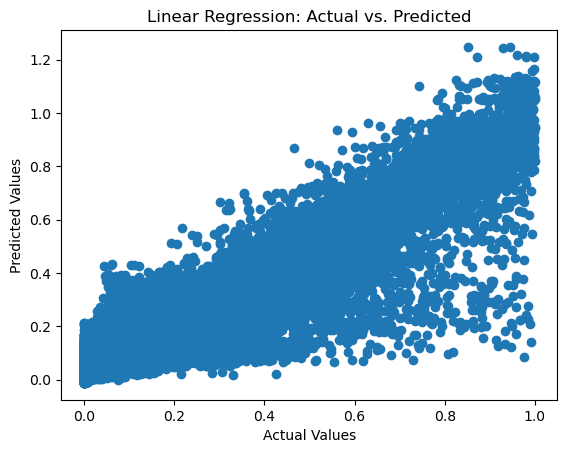

In [ ]:
from sklearn.preprocessing import StandardScaler
# Splitting the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the Linear Regression model
model = LinearRegression()

# Fit the model to your training data
model.fit(X_train_scaled, y_train)

# Now you can use the model to predict using the test data
y_pred = model.predict(X_test_scaled)

# Printing the predictions
print("Predictions:", y_pred)
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Absolute Error", metrics.mean_absolute_error(y_test, y_pred))
print("Mean Squared Error", metrics.mean_squared_error(y_test, y_pred))
print("RMSE", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("R2", metrics.explained_variance_score(y_test, y_pred))

print("Mean Squared Error:", mse)
print("R-squared:", r2)
# Visualize the results
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Linear Regression: Actual vs. Predicted")
plt.show()

In [ ]:
table = PrettyTable(["Prediction Index", "Predicted Value"])

# Sort predictions and get the indices of the top 5 predictions
top_indices = sorted(range(len(y_pred)), key=lambda i: y_pred[i], reverse=True)[:5]

for index in top_indices:
    # Add top predictions to the table with values rounded to 4 decimal places
    table.add_row([index, round(y_pred[index], 4)])

# Print the table with top predictions
print("Top 5 Predictions:")
print(table)

Top 5 Predictions:
+------------------+-----------------+
| Prediction Index | Predicted Value |
+------------------+-----------------+
|      59789       |      1.2472     |
|      61020       |      1.2464     |
|       5055       |      1.2421     |
|      73456       |      1.2185     |
|      65949       |      1.2145     |
+------------------+-----------------+


XGBOOST REGRESSOR MODEL

In [ ]:
import xgboost as xgb

#X = data.drop(["Weekly_Sales"], axis=1)  # independent variables
#y = data["Weekly_Sales"]  # dependent variable

# Split data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Define your features and target variable
feature_cols = [
    "Size",
    "Temperature",
    "Fuel_Price",
    "CPI",
    "Unemployment",
    "Total_MarkDown",
    "Year",
    "Month",
    "Week",
]
X = data[feature_cols]
y = data["Weekly_Sales"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dtrain = xgb.XGBRegressor(X_train, label=y_train.values)
dtest = xgb.XGBRegressor(X_test, label=y_test.values)

# Initialize and train the XGBoost model
xgb_model = XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1, random_state=42)

xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

# Optionally, plot feature importance
import matplotlib.pyplot as plt
xgb.plot_importance(xgb_model)
plt.title("Feature Importance")
plt.show()

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:Week: UInt32